In [1]:
import re
import os
import jax
import pickle
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["lines.linewidth"] = 2

In [3]:
def get_subtree(tree, key):
    return jax.tree_map(lambda x: x[key], tree, is_leaf=lambda x: key in x)


def extract_data(files, base_path):
    regexp = re.compile("rank([0-9]+).pkl")
    data_all = {}
    for file in files:
        m = regexp.findall(file)
        if len(m) == 0:
            continue
            rank = 50
        else:
            rank = int(m[0])

        file_path = os.path.join(base_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        data_all[rank] = data
    return data_all



def extract_data_passes(files, base_path):
    regexp = re.compile("rank([0-9]+)_([0-9]+)pass.pkl")
    data_all = {}
    for file in files:
        m = regexp.findall(file)
        if len(m) == 0:
            continue
        else:
            rank = int(m[0][0])

        file_path = os.path.join(base_path, file)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
        
        data = {
            **data,
        }
        data_all[rank] = data
    return data_all


def extract_filenames_passes(dataset, base_path, npass):
    files = os.listdir(path)
    files_target = [file for file in files if dataset in file]
    
    if npass == 1:
        files_target = [file for file in files_target if "pass" not in file]
    else:
        files_target = [file for file in files_target if f"{npass}pass" in file]
    
    return files_target


def extract_filenames(dataset, base_path, npass):
    files = os.listdir(path)
    files_target = [file for file in files if (dataset in file) and (f"{npass}pass" in file)]
    return files_target



def build_df_summary(data, dataset_name):
    """
    Summary over the last-observed value
    """
    # agent_last = jax.tree_map(lambda x: x[:, -1], data)
    agent_last = jax.tree_map(lambda x: np.atleast_1d(np.take(x, -1, -1)), data)
    df_summary = []
    for key in agent_last:
        piece = pd.DataFrame(agent_last[key])

        if key != 1:
            drop_cols = ["fdekf", "vdekf"]
            piece = piece.drop(drop_cols, axis=1)
        if key != 2:
            drop_cols = ["fcekf"]
            piece = piece.drop(drop_cols, axis=1)


        piece = piece.melt()
        piece["rank"] = key
        df_summary.append(piece)
    df_summary = pd.concat(df_summary).dropna(axis=0)
    df_summary = df_summary.query("variable != 'lofi_orth'")

    df_summary.loc[df_summary["variable"] == "fcekf", "rank"] = "full"
    df_summary.loc[df_summary["variable"] == "fdekf", "rank"] = 0
    df_summary.loc[df_summary["variable"] == "vdekf", "rank"] = 0
    df_summary = df_summary.assign(dataset=dataset_name)
    return df_summary

## Setup

In [4]:
path = "./output/cross-validation"

In [5]:
all_files = os.listdir(path)
datasets = list(set([f.split("_")[0].split(".")[0] for f in all_files]))

void_datasets = ["protein-tertiary-structure"]
datasets = [d for d in datasets if d not in void_datasets]
sorted(datasets)

['bostonHousing',
 'concrete',
 'energy',
 'kin8nm',
 'naval-propulsion-plant',
 'power-plant',
 'wine-quality-red',
 'yacht']

In [6]:
regexp = re.compile("[a-z0-9]+")
dataset_map = {
    name: regexp.search(name)[0].capitalize()
    for name in sorted(datasets)
}

In [7]:
npasses_list = [1, 10, 50]

df_summary_all = []
for npasses in npasses_list:
    df_summaries = []
    for dataset in datasets:
        files_target = extract_filenames_passes(dataset, path, npasses)
        if len(files_target) == 0:
            continue

        if npasses == 1:
            data_dataset = extract_data(files_target, path)
        else:
            data_dataset = extract_data_passes(files_target, path)

        data_test = get_subtree(data_dataset, "test")
        df_summary = build_df_summary(data_test, dataset)
        df_summary["n_passes"] = npasses
        df_summaries.append(df_summary)
    df_summaries = pd.concat(df_summaries, axis=0)
    df_summary_all.append(df_summaries)
df_summary_all = pd.concat(df_summary_all, axis=0)

In [8]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

In [248]:
def format_method(row):
    agent = row["variable"]
    npasses = row["n_passes"].astype(str)
    label = agent + " n. pass (" + npasses + ")"
    return label



df = (
    df_summary_all
    # .query("n_passes <= 10")
    .query("dataset == 'energy'")
    .query("variable != 'vdekf'")
    .query("variable != 'lofi_diag'")
    .assign(method=format_method)
)

# df.loc[df["rank"] == "full", "rank"] = 100
# df["rank"] = df["rank"].astype(int)

In [345]:
methods_unique

array(['fdekf n. pass (1)', 'lofi n. pass (1)', 'lrvga n. pass (1)',
       'sgd-rb n. pass (1)', 'fcekf n. pass (1)', 'fdekf n. pass (10)',
       'lofi n. pass (10)', 'sgd-rb n. pass (10)', 'fcekf n. pass (10)',
       'fdekf n. pass (50)', 'lofi n. pass (50)', 'sgd-rb n. pass (50)',
       'fcekf n. pass (50)'], dtype=object)

In [342]:
n_passes = [1, 10, 50]
# cmaps = [plt.cm.spring, plt.cm.winter_r, plt.cm.bone]
cmaps = [plt.cm.Purples, plt.cm.Greens, plt.cm.Reds]

methods_unique = df["method"].unique()

methods_map = {}
for n, cmap in zip(n_passes, cmaps):
    methods_n = []
    for method in methods_unique:
        if (f"({n})" in method):
            methods_n.append(method)
    methods_map[n] = methods_n
    
    
methods_colors = {}
for k, cmap in zip(methods_map, cmaps):
    methods = methods_map[k]
    nmethods = len(methods)
    colors = cmap(np.linspace(0.2, 1, nmethods))
    
    cpart = {m:c for m, c in zip(methods, colors)}
    methods_colors = {**methods_colors, **cpart}

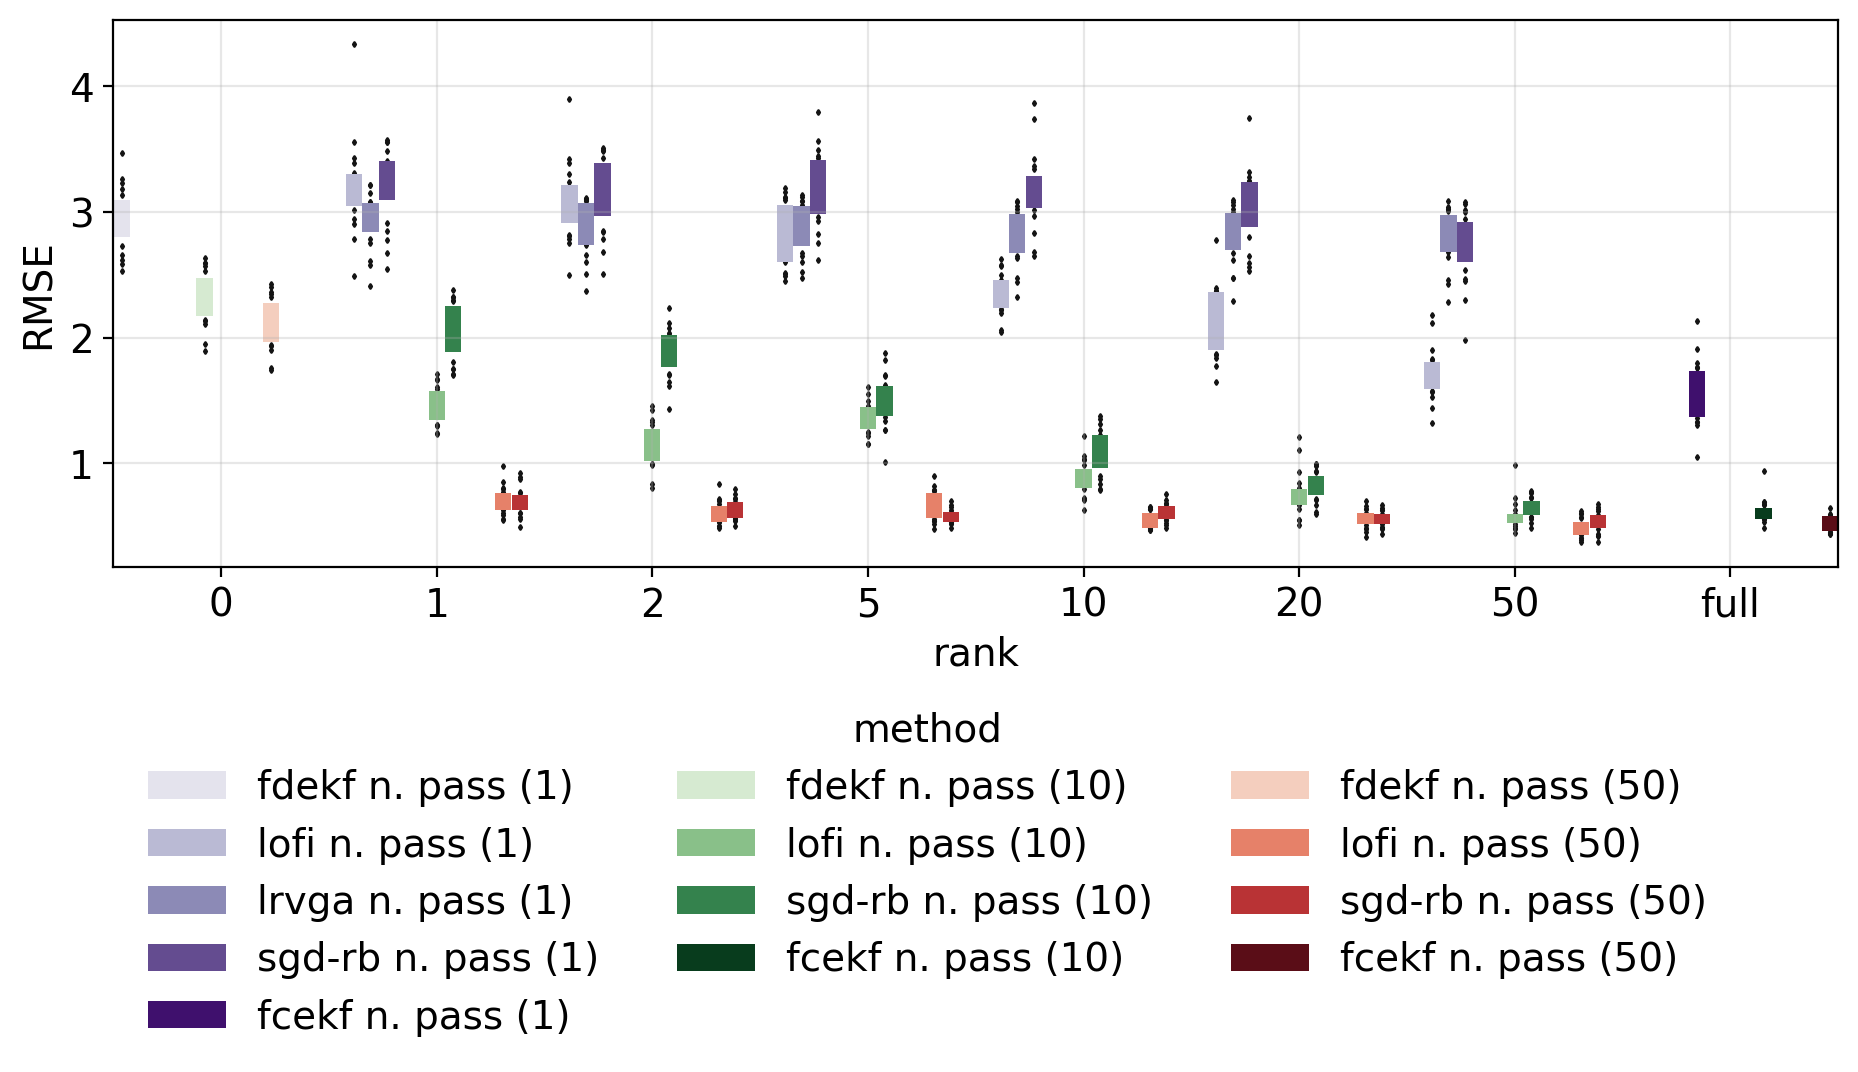

In [371]:
cols_sort = [0, 1, 2, 5, 10, 20, 50, "full"]
# cols_sort = [0, 1, 2, 5, 10, 20, 50, 100]
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxenplot(
    x="rank",
    y="value",
    # hue="variable",
    hue="method",
    data=df,
    order=cols_sort,
    hue_order=methods_colors,
    palette=methods_colors,
    width=1,
    linewidth=0.0,
    flier_kws={"s": 1},
    ax=ax
)

plt.ylabel("RMSE")
plt.legend(loc="upper left", title="method", bbox_to_anchor=(0, -0.2), ncols=3, frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
# figname = f"./output/images/{dataset}-rank-passes.pdf"
# plt.savefig(figname)
# print(figname)

./output/images/energy-rank-passes.pdf


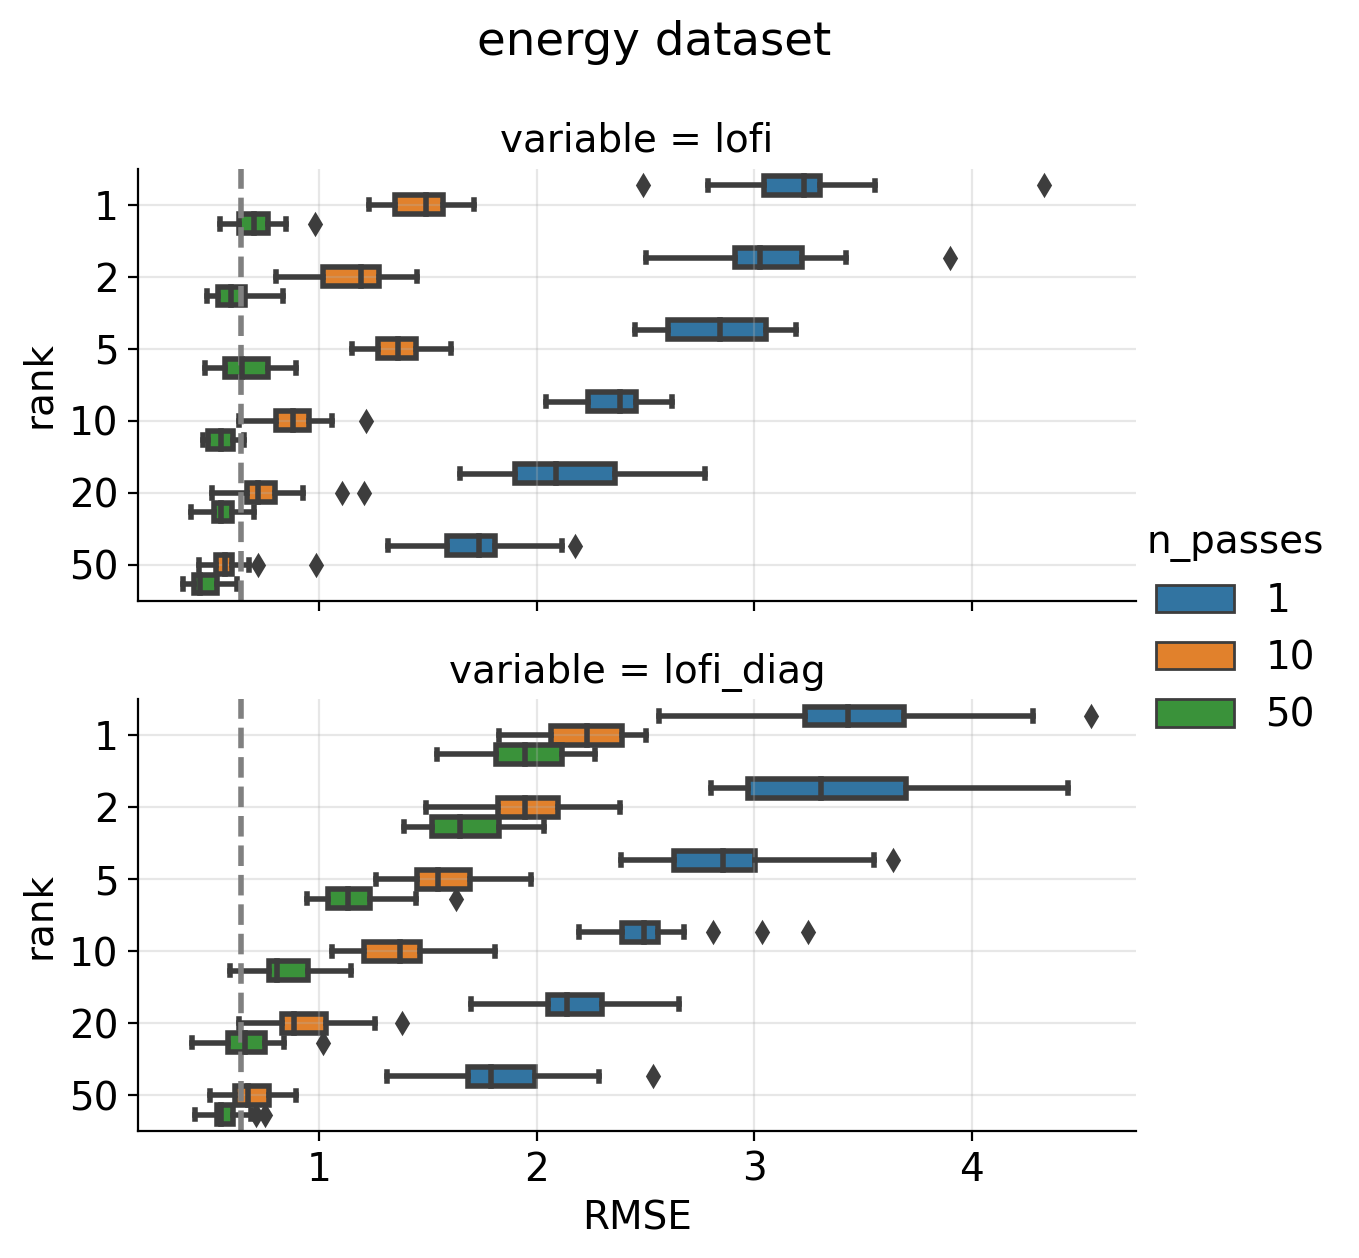

In [9]:
dataset = "energy"
agents = ["lofi", "lofi_diag"]
# agents = ["sgd-rb", "lofi"]

g = sns.catplot(
    data=(
        df_summary_all
        .sort_values(by="variable")
        .query("dataset == @dataset")
        .query("variable in @agents")
    ),
    x="value", y="rank", hue="n_passes",
    row="variable",
    orient="h",
    kind="box",
    sharex=True,
    height=3, aspect=2,
)
for ax in g.axes.ravel():
    v = ax.axvline(x=0.64, linestyle="--", c="gray")
    ax.grid(alpha=0.3)
plt.xlabel("RMSE")
plt.suptitle(f"{dataset} dataset", y=1.05)
# plt.tight_layout()

figname = f"./output/images/{dataset}-rank-passes.pdf"
plt.savefig(figname)
print(figname)

In [324]:
def format_entry(entry):
    mean = entry.mean()
    std = entry.std()
    label = rf"${mean:0.2f} \pm {std:0.2f}$"
    return label

In [325]:
aggfunc = "mean"
# aggfunc = format_entry
# aggfunc = lambda x: f"${x.mean():0.2f}$"

res = (
    df_summary_all
    .query("(rank == 10) or (rank == 0) or (rank == 'full')")
    .pivot_table(
         index=["n_passes", "rank", "variable"], columns="dataset",
        # index=["variable", " n_passes"], columns="dataset",
        values="value", aggfunc=aggfunc
    )
).rename(dataset_map, axis=1)
# print(res.style.to_latex())

In [326]:
res

dataset                    Boston   Concrete     Energy    Kin8nm     Naval  \
n_passes rank variable                                                        
1        0    fdekf      5.234724   8.597416   2.962508  0.120360  0.012058   
              vdekf      9.033447  16.345562   9.441345  0.141021  0.010842   
         10   lofi       5.116864   7.268073   2.356136  0.120652  0.001191   
              lofi_diag  4.769196   7.326795   2.530251  0.143918  0.001194   
              lrvga      3.623823   7.279297   2.800892  0.119086  0.002100   
              sgd-rb     4.414332   8.460921   3.181982  0.131691  0.001844   
         full fcekf      4.042458   6.448200   1.582862  0.100185  0.000575   
10       0    fdekf      3.200195   6.684844   2.319361  0.097708  0.007783   
              vdekf      9.033447  16.345562  10.100312  0.109991  0.009226   
         10   lofi       5.375212   5.625003   0.884825  0.096249  0.000428   
              lofi_diag  5.081882   5.855386   1.361698  0.091539  0.000910   
              sgd-rb     3.631007   6.287568   1.075345  0.100011  0.000398   
         full fcekf      3.133571   5.312020   0.618029  0.088742  0.000248   
50       0    fdekf      2.948403   6.371103   2.107927  0.094334  0.006498   
              vdekf      9.033447  16.345562  10.100312  0.102222  0.008759   
         10   lofi       5.292725   5.413264   0.555733  0.088247  0.000217   
              lofi_diag  4.994887   5.533679   0.859483  0.087659  0.000729   
              sgd-rb     3.518690   5.783340   0.601427  0.095408  0.000310   
         full fcekf      3.621420   5.117215   0.522022  0.085947  0.000167   

dataset                     Power      Wine     Yacht  
n_passes rank variable                                 
1        0    fdekf      4.238136  0.820677  5.132223  
              vdekf      4.250752  0.658894  5.599589  
         10   lofi       4.202857  0.650432  4.658266  
              lofi_diag  4.371668  0.715969  4.660659  
              lrvga      4.217532  0.651245  3.387812  
              sgd-rb     4.814272  0.696468  7.918941  
         full fcekf      4.126744  0.657284  3.144549  
10       0    fdekf      4.175329  0.820677  1.175395  
              vdekf      4.195266  0.635092  2.318470  
         10   lofi       4.136571  0.643280  1.513051  
              lofi_diag  4.128115  0.635003  2.256105  
              sgd-rb     4.733196  0.710499  2.262869  
         full fcekf      4.046157  0.637591  1.188529  
50       0    fdekf      4.144581  0.820677  0.802822  
              vdekf      4.169378  0.629555  1.617163  
         10   lofi       4.062895  0.664792  0.923578  
              lofi_diag  4.098559  0.633065  1.364621  
              sgd-rb     4.741079  0.794520  0.810538  
         full fcekf      4.002561  0.682566  1.119903

In [327]:
print(res.style.to_latex(hrules=True).replace("_", "-"))

\begin{tabular}{lllrrrrrrrr}
\toprule
 &  & dataset & Boston & Concrete & Energy & Kin8nm & Naval & Power & Wine & Yacht \\
n-passes & rank & variable &  &  &  &  &  &  &  &  \\
\midrule
\multirow[c]{7}{*}{1} & \multirow[c]{2}{*}{0} & fdekf & 5.234724 & 8.597416 & 2.962508 & 0.120360 & 0.012058 & 4.238136 & 0.820677 & 5.132223 \\
 &  & vdekf & 9.033447 & 16.345562 & 9.441345 & 0.141021 & 0.010842 & 4.250752 & 0.658894 & 5.599589 \\
 & \multirow[c]{4}{*}{10} & lofi & 5.116864 & 7.268073 & 2.356136 & 0.120652 & 0.001191 & 4.202857 & 0.650432 & 4.658266 \\
 &  & lofi-diag & 4.769196 & 7.326795 & 2.530251 & 0.143918 & 0.001194 & 4.371668 & 0.715969 & 4.660659 \\
 &  & lrvga & 3.623823 & 7.279297 & 2.800892 & 0.119086 & 0.002100 & 4.217532 & 0.651245 & 3.387812 \\
 &  & sgd-rb & 4.414332 & 8.460921 & 3.181982 & 0.131691 & 0.001844 & 4.814272 & 0.696468 & 7.918941 \\
 & full & fcekf & 4.042458 & 6.448200 & 1.582862 & 0.100185 & 0.000575 & 4.126744 & 0.657284 & 3.144549 \\
\multirow[c]{6}{*}{

In [328]:
print(res.style.to_latex().replace("_", "-").replace("nan", "$-$"))

\begin{tabular}{lllrrrrrrrr}
 &  & dataset & Boston & Concrete & Energy & Kin8nm & Naval & Power & Wine & Yacht \\
n-passes & rank & variable &  &  &  &  &  &  &  &  \\
\multirow[c]{7}{*}{1} & \multirow[c]{2}{*}{0} & fdekf & 5.234724 & 8.597416 & 2.962508 & 0.120360 & 0.012058 & 4.238136 & 0.820677 & 5.132223 \\
 &  & vdekf & 9.033447 & 16.345562 & 9.441345 & 0.141021 & 0.010842 & 4.250752 & 0.658894 & 5.599589 \\
 & \multirow[c]{4}{*}{10} & lofi & 5.116864 & 7.268073 & 2.356136 & 0.120652 & 0.001191 & 4.202857 & 0.650432 & 4.658266 \\
 &  & lofi-diag & 4.769196 & 7.326795 & 2.530251 & 0.143918 & 0.001194 & 4.371668 & 0.715969 & 4.660659 \\
 &  & lrvga & 3.623823 & 7.279297 & 2.800892 & 0.119086 & 0.002100 & 4.217532 & 0.651245 & 3.387812 \\
 &  & sgd-rb & 4.414332 & 8.460921 & 3.181982 & 0.131691 & 0.001844 & 4.814272 & 0.696468 & 7.918941 \\
 & full & fcekf & 4.042458 & 6.448200 & 1.582862 & 0.100185 & 0.000575 & 4.126744 & 0.657284 & 3.144549 \\
\multirow[c]{6}{*}{10} & \multirow[c]

In [360]:
aggfunc = "mean"
aggfunc = format_entry
# aggfunc = lambda x: f"${x.mean():0.2f}$"

res = (
    df_summary_all
    .query("n_passes==50")
    .query("variable != 'vdekf'")
    .pivot_table(
        # index=["rank", "variable"], columns=["dataset", "n_passes"],
        index=["rank", "variable"], columns=["dataset"],
        values="value", aggfunc=aggfunc
    )
).rename(dataset_map, axis=1)
res

dataset                  Boston         Concrete           Energy  \
rank variable                                                       
0    fdekf      $2.95 \pm 0.71$  $6.37 \pm 0.52$  $2.11 \pm 0.21$   
1    lofi       $5.70 \pm 1.28$  $5.89 \pm 0.90$  $0.71 \pm 0.11$   
     lofi_diag  $5.48 \pm 1.17$  $5.88 \pm 0.47$  $1.96 \pm 0.20$   
     sgd-rb     $3.28 \pm 0.85$  $5.70 \pm 0.76$  $0.69 \pm 0.11$   
2    lofi       $3.26 \pm 0.85$  $5.75 \pm 0.74$  $0.61 \pm 0.09$   
     lofi_diag  $5.13 \pm 1.10$  $5.81 \pm 0.47$  $1.68 \pm 0.19$   
     sgd-rb     $3.27 \pm 0.83$  $5.74 \pm 0.81$  $0.64 \pm 0.08$   
5    lofi       $3.10 \pm 0.84$  $5.82 \pm 0.75$  $0.67 \pm 0.12$   
     lofi_diag  $4.92 \pm 1.13$  $5.44 \pm 0.46$  $1.17 \pm 0.17$   
     sgd-rb     $3.38 \pm 0.77$  $6.04 \pm 0.87$  $0.58 \pm 0.06$   
10   lofi       $5.29 \pm 1.12$  $5.41 \pm 0.64$  $0.56 \pm 0.07$   
     lofi_diag  $4.99 \pm 1.10$  $5.53 \pm 0.50$  $0.86 \pm 0.14$   
     sgd-rb     $3.52 \pm 0.68$  $5.78 \pm 0.87$  $0.60 \pm 0.07$   
20   lofi       $5.01 \pm 1.09$  $5.14 \pm 0.69$  $0.56 \pm 0.07$   
     lofi_diag  $5.01 \pm 1.10$  $5.35 \pm 0.45$  $0.67 \pm 0.15$   
     sgd-rb     $3.76 \pm 0.74$  $5.86 \pm 0.83$  $0.56 \pm 0.06$   
50   lofi       $5.00 \pm 1.12$  $5.09 \pm 0.66$  $0.48 \pm 0.08$   
     lofi_diag  $5.01 \pm 1.11$  $5.27 \pm 0.58$  $0.57 \pm 0.08$   
     sgd-rb     $4.05 \pm 1.02$  $5.81 \pm 0.65$  $0.53 \pm 0.08$   
full fcekf      $3.62 \pm 1.28$  $5.12 \pm 0.59$  $0.52 \pm 0.06$   

dataset                  Kin8nm            Naval            Power  \
rank variable                                                       
0    fdekf      $0.09 \pm 0.00$  $0.01 \pm 0.00$  $4.14 \pm 0.16$   
1    lofi       $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.15 \pm 0.16$   
     lofi_diag  $0.10 \pm 0.00$  $0.00 \pm 0.00$  $4.15 \pm 0.16$   
     sgd-rb     $0.08 \pm 0.00$  $0.00 \pm 0.00$  $4.13 \pm 0.20$   
2    lofi       $0.29 \pm 0.05$  $0.00 \pm 0.00$  $4.13 \pm 0.15$   
     lofi_diag  $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.15 \pm 0.16$   
     sgd-rb     $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.20 \pm 0.24$   
5    lofi       $0.19 \pm 0.09$  $0.00 \pm 0.00$  $4.13 \pm 0.15$   
     lofi_diag  $0.10 \pm 0.00$  $0.00 \pm 0.00$  $4.10 \pm 0.17$   
     sgd-rb     $0.09 \pm 0.01$  $0.00 \pm 0.00$  $4.36 \pm 0.30$   
10   lofi       $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.06 \pm 0.17$   
     lofi_diag  $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.10 \pm 0.16$   
     sgd-rb     $0.10 \pm 0.01$  $0.00 \pm 0.00$  $4.74 \pm 0.38$   
20   lofi       $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.12 \pm 0.19$   
     lofi_diag  $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.06 \pm 0.16$   
     sgd-rb     $0.10 \pm 0.01$  $0.00 \pm 0.00$  $4.89 \pm 0.54$   
50   lofi       $0.08 \pm 0.00$  $0.02 \pm 0.00$  $4.05 \pm 0.17$   
     lofi_diag  $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.05 \pm 0.17$   
     sgd-rb     $0.10 \pm 0.00$  $0.00 \pm 0.00$  $4.73 \pm 0.35$   
full fcekf      $0.09 \pm 0.00$  $0.00 \pm 0.00$  $4.00 \pm 0.17$   

dataset                    Wine            Yacht  
rank variable                                     
0    fdekf      $0.82 \pm 0.05$  $0.80 \pm 0.26$  
1    lofi       $0.66 \pm 0.05$  $0.96 \pm 0.28$  
     lofi_diag  $0.63 \pm 0.04$  $1.19 \pm 0.28$  
     sgd-rb     $0.66 \pm 0.05$  $1.33 \pm 0.35$  
2    lofi       $0.66 \pm 0.05$  $1.06 \pm 0.28$  
     lofi_diag  $0.63 \pm 0.04$  $1.30 \pm 0.38$  
     sgd-rb     $0.69 \pm 0.06$  $1.13 \pm 0.37$  
5    lofi       $0.65 \pm 0.05$  $1.05 \pm 0.23$  
     lofi_diag  $0.63 \pm 0.04$  $1.08 \pm 0.29$  
     sgd-rb     $0.73 \pm 0.07$  $0.95 \pm 0.32$  
10   lofi       $0.66 \pm 0.05$  $0.92 \pm 0.27$  
     lofi_diag  $0.63 \pm 0.04$  $1.36 \pm 0.33$  
     sgd-rb     $0.79 \pm 0.08$  $0.81 \pm 0.25$  
20   lofi       $0.67 \pm 0.04$  $1.17 \pm 0.23$  
     lofi_diag  $0.63 \pm 0.04$  $1.03 \pm 0.28$  
     sgd-rb     $0.85 \pm 0.08$  $0.78 \pm 0.26$  
50   lofi       $0.68 \pm 0.06$  $0.93 \pm 0

In [361]:
print(res.style.to_latex().replace("_", "-").replace("nan", "-"))

\begin{tabular}{llllllllll}
 & dataset & Boston & Concrete & Energy & Kin8nm & Naval & Power & Wine & Yacht \\
rank & variable &  &  &  &  &  &  &  &  \\
0 & fdekf & $2.95 \pm 0.71$ & $6.37 \pm 0.52$ & $2.11 \pm 0.21$ & $0.09 \pm 0.00$ & $0.01 \pm 0.00$ & $4.14 \pm 0.16$ & $0.82 \pm 0.05$ & $0.80 \pm 0.26$ \\
\multirow[c]{3}{*}{1} & lofi & $5.70 \pm 1.28$ & $5.89 \pm 0.90$ & $0.71 \pm 0.11$ & $0.09 \pm 0.00$ & $0.00 \pm 0.00$ & $4.15 \pm 0.16$ & $0.66 \pm 0.05$ & $0.96 \pm 0.28$ \\
 & lofi-diag & $5.48 \pm 1.17$ & $5.88 \pm 0.47$ & $1.96 \pm 0.20$ & $0.10 \pm 0.00$ & $0.00 \pm 0.00$ & $4.15 \pm 0.16$ & $0.63 \pm 0.04$ & $1.19 \pm 0.28$ \\
 & sgd-rb & $3.28 \pm 0.85$ & $5.70 \pm 0.76$ & $0.69 \pm 0.11$ & $0.08 \pm 0.00$ & $0.00 \pm 0.00$ & $4.13 \pm 0.20$ & $0.66 \pm 0.05$ & $1.33 \pm 0.35$ \\
\multirow[c]{3}{*}{2} & lofi & $3.26 \pm 0.85$ & $5.75 \pm 0.74$ & $0.61 \pm 0.09$ & $0.29 \pm 0.05$ & $0.00 \pm 0.00$ & $4.13 \pm 0.15$ & $0.66 \pm 0.05$ & $1.06 \pm 0.28$ \\
 & lofi-diag & $5.13

## Time analysis

In [362]:
npasses_list = [1, 10, 50]

df_summary_all = []
for npasses in npasses_list:
    df_summaries = []
    for dataset in datasets:
        files_target = extract_filenames_passes(dataset, path, npasses)
        if len(files_target) == 0:
            continue

        if npasses == 1:
            data_dataset = extract_data(files_target, path)
        else:
            data_dataset = extract_data_passes(files_target, path)

        data_test = get_subtree(data_dataset, "running_time")
        df_summary = build_df_summary(data_test, dataset)
        df_summary["n_passes"] = npasses
        df_summaries.append(df_summary)
    df_summaries = pd.concat(df_summaries, axis=0)
    df_summary_all.append(df_summaries)
df_summary_all = pd.concat(df_summary_all, axis=0)

In [468]:
aggfunc="mean"
# aggfunc = lambda x: f"${x.mean():0.2f}$"

res = (
    df_summary_all
    .query("variable != 'vdekf'")
    .query("n_passes == 10")
    .pivot_table(index=["rank", "variable"], columns="dataset", values="value", aggfunc=aggfunc) 
).rename(dataset_map, axis=1)
res 

dataset            Boston   Concrete     Energy      Kin8nm        Naval  \
rank variable                                                              
0    fdekf       1.609879   1.954202   1.712306   14.402359    25.779103   
1    lofi        3.238832   5.341731   4.086306   25.678344    36.056354   
     lofi_diag   8.221431  13.442220  11.664677   68.000605    85.989037   
     sgd-rb      1.367398   1.641828   1.476698    5.878901     8.796443   
2    lofi        3.269826   4.949272   4.178496   27.739945    38.254832   
     lofi_diag  11.909006  18.432232  15.949951  111.697418   159.073684   
     sgd-rb      1.877486   2.443693   2.160726   11.504315    16.662849   
5    lofi        3.593339   6.323839   4.721483   33.210499    45.767524   
     lofi_diag  13.285800  21.516290  17.178106  137.867040   194.984083   
     sgd-rb      1.900550   2.536641   2.124079   11.592182    17.006077   
10   lofi        5.109020   7.173432   7.042652   44.896349    66.246328   
     lofi_diag  16.917574  28.447202  22.608319  197.275967   267.625425   
     sgd-rb      1.989904   2.514518   2.241548   11.953623    17.671822   
20   lofi        6.671481  10.288386   8.985671   76.316943   104.632782   
     lofi_diag  24.823847  43.339102  34.757690  319.621577   445.774406   
     sgd-rb      2.378078   2.593124   2.201127   12.487924    18.036680   
50   lofi       14.483202  23.797131  18.433468  171.615921   372.449042   
     lofi_diag  53.248136  95.939947  75.324572  739.091701  1049.381986   
     sgd-rb      2.188155   3.067379   2.556773   16.136312    23.995368   
full fcekf       2.603956   2.857554   2.370430   22.348276    61.833455   

dataset              Power        Wine      Yacht  
rank variable                                      
0    fdekf       18.049311    2.292405   1.334127  
1    lofi        28.770470    6.384887   2.803156  
     lofi_diag   74.047567   17.147565   7.924088  
     sgd-rb       6.621962    2.049052   1.188979  
2    lofi        30.649513    6.558024   2.678196  
     lofi_diag  127.775878   25.570282   9.035964  
     sgd-rb      13.326061    3.277807   1.578004  
5    lofi        37.112142    7.597712   4.650542  
     lofi_diag  157.351746   30.171611   9.875241  
     sgd-rb      13.301363    3.287896   1.583262  
10   lofi        49.260305    9.659734   3.414439  
     lofi_diag  208.775790   39.345498  11.573728  
     sgd-rb      13.475124    3.483081   1.587369  
20   lofi        84.916745   15.380448   4.567636  
     lofi_diag  358.456967   62.390211  16.721828  
     sgd-rb      14.012040    3.536611   1.619619  
50   lofi       189.798918   34.447174   8.692440  
     lofi_diag  841.487556  141.837164  32.507099  
     sgd-rb      18.588148    6.155692   1.780440  
full fcekf       21.661020    5.341812   1.537831

In [380]:
df_summary_all.query("variable != 'vdekf'").query("n_passes == 1")

,variable,value,rank,dataset,n_passes
0,fdekf,1.307217,0,wine-quality-red,1
1,lofi,2.400970,1,wine-quality-red,1
2,lofi_diag,2.400184,1,wine-quality-red,1
4,lrvga,69.738953,1,wine-quality-red,1
5,sgd-rb,1.153914,1,wine-quality-red,1
...,...,...,...,...,...
4,sgd-rb,1.248193,20,bostonHousing,1
0,lofi,3.238824,50,bostonHousing,1
1,lofi_diag,3.437154,50,bostonHousing,1
2,lrvga,36.653862,50,bostonHousing,1


In [475]:
df_summary_all["variable"] = df_summary_all["variable"].str.replace("_", "-")
df_summary_all.loc[df_summary_all["variable"] == "lofi", "variable"] = "lofi-sph"

./output/images/energy-running-time.pdf


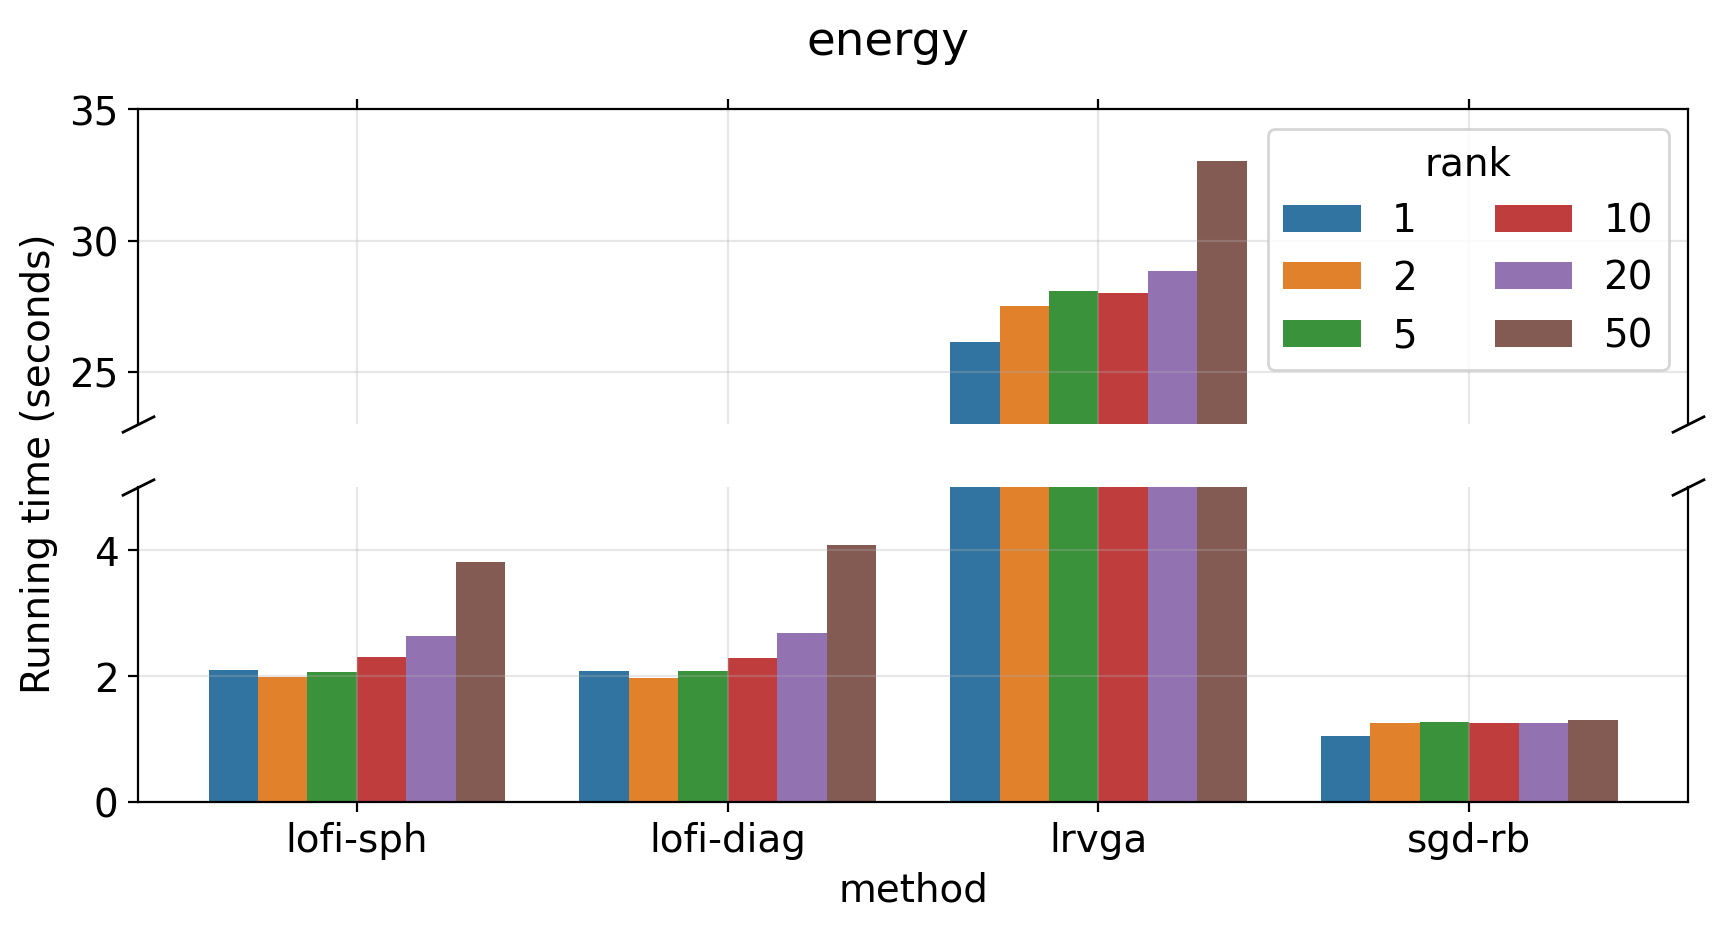

In [476]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 4.5))

df = (    df_summary_all
    .query("variable != 'vdekf'")
     .query("variable != 'fdekf'")
      .query("variable != 'fcekf'")
    .query("n_passes == 1")
 .query("dataset == @dataset")
)

dataset = "energy"
sns.barplot(
    ax=ax2,
    x="variable", y="value", hue="rank",
    hue_order=cols_sort[1:-1],
    data=df
)


sns.barplot(
    ax=ax1,
    x="variable", y="value", hue="rank",
    hue_order=cols_sort[1:-1],
    data=df
)


ax1.set_ylim(23, 35)  # outliers only
ax2.set_ylim(0, 5)  # most of the data

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax1.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xlabel("method")
ax1.set_ylabel("Running time (seconds)          ", loc="top")
ax2.legend([], frameon=False)
ax1.legend(loc="upper right", title="rank", ncols=2)
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.grid(alpha=0.3)
ax2.grid(alpha=0.3)

# plt.grid(alpha=0.3)

# plt.ylabel("Running time (seconds)")
 
# plt.tight_layout()

plt.suptitle(dataset)
figname = f"./output/images/{dataset}-running-time.pdf"
plt.savefig(figname)
print(figname)